In [1]:
import torch
import numpy as np
import math
from typing import Dict, List, Tuple, Any
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor, device
from torch.nn.utils.parametrizations import weight_norm
from torch.optim.swa_utils import AveragedModel, get_ema_multi_avg_fn
from torch.utils.data import random_split, TensorDataset, DataLoader
from torch.utils.checkpoint import checkpoint
from torch.utils.tensorboard.writer import SummaryWriter
from config import NODE_FEATURE_DIMENSION, EDGE_FEATURE_DIMENSION, MAX_NUM_PRIMITIVES, GRAPH_EMBEDDING_SIZE
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from dataset1 import SketchDataset
from tqdm import tqdm
from functools import partial
from IPython import display
import os

### TRAINING HELPERS

In [2]:
# class GradientParameterMonitor:
#     def __init__(self, model, writer : SummaryWriter, log_frequency=100):
#         self.model = model
#         self.log_frequency = log_frequency
#         self.step = 0
#         self.writer = writer

#     def update(self):
#         self.step += 1
#         if self.step % self.log_frequency == 0:
#             for name, param in self.model.named_parameters():
#                 if "node" in name:
#                     if param.grad is not None:
#                         self._log_tensor_stats(f'{name}/grad', param.grad)
#                     self._log_tensor_stats(f'{name}/param', param.data)

#     def _log_tensor_stats(self, tag_prefix, tensor):
#         stats = self._get_tensor_stats(tensor)
#         for stat_name, value in stats.items():
#             self.writer.add_scalar(f'Monitor/{tag_prefix}/{stat_name}', value, self.step)

#     def _get_tensor_stats(self, tensor):
#         return {
#             'mean': tensor.mean().item(),
#             # 'std': tensor.std().item(),
#             'min': tensor.min().item(),
#             'max': tensor.max().item(),
#             # 'norm': torch.norm(tensor).item()
#         }

In [3]:
# @torch.no_grad()
# def batched_dot(a : Tensor, b : Tensor):
#     return (a * b).sum(dim = -1, keepdim = True)

# @torch.no_grad()
# def ToIscosceles(x : Tensor):
#     m = torch.tensor([[0.0, -1.0], [1.0, 0.0]], device = x.device).to(torch.double)

#     # To Iscosceles representation
#     y = x.clone().to(torch.double)
#     c = y[...,13:15] # torch.tensor([1.76, 2.21])
#     r = y[...,15,None] # torch.tensor([1.0])
#     alpha = y[...,16,None] * 2 * math.pi # torch.tensor([0.211])
#     beta = y[...,17,None] * 2 * math.pi # torch.tensor([0.987])

#     a = c + r * torch.cat([alpha.cos(), alpha.sin()], dim = -1)
#     b = c + r * torch.cat([beta.cos(), beta.sin()], dim = -1)
#     r_s = torch.where(batched_dot((a - b) @ m, a - c) > 0, -r, r)

#     y[...,13:15] = a
#     y[...,15:17] = b
#     y[...,17] = r_s.squeeze(-1)

#     return y.to(torch.float32)

# @torch.no_grad()
# def ToNaive(x : Tensor):
#     m = torch.tensor([[0.0, -1.0], [1.0, 0.0]], device = x.device).to(torch.double)

#     x = x.clone().to(torch.double)
#     a = x[...,13:15]
#     b = x[...,15:17]
#     r_s = x[...,17,None]

#     # To Naive representation
#     d = a - b

#     w = batched_dot(d, d).sqrt()
#     h = torch.sqrt(r_s ** 2 - w ** 2 / 4)

#     c = b + d / 2 + h / w * d @ m * r_s.sign()

#     al = (a - c) / r_s.abs()
#     al = (torch.atan2(al[...,1], al[...,0]).unsqueeze(-1) % (2 * math.pi)) / (2 * math.pi)
#     be = (b - c) / r_s.abs()
#     be = (torch.atan2(be[...,1], be[...,0]).unsqueeze(-1) % (2 * math.pi)) / (2 * math.pi)

#     x[...,13:18] = torch.cat([c, torch.abs(r_s), al, be], dim = -1)
#     x[x.isnan()] = 0
#     return x.to(torch.float)


### MODULES

In [4]:
class CosineNoiseScheduler(nn.Module):
  def __init__(self, max_timestep : int, device : torch.device):
    super().__init__()
    self.device = device
    self.max_timestep = max_timestep
    self.offset = .008 # Fixed offset to improve noise prediction at early timesteps

    # Cosine Beta Schedule Formula: https://arxiv.org/abs/2102.09672
    # self.a_bar = torch.cos((torch.linspace(0, 1, self.max_timestep + 1).to(self.device) + self.offset) * 0.5 * math.pi / (1 + self.offset)) ** 2
    # self.a_bar = self.a_bar / self.a_bar[0]
    # self.a_bar = self.a_bar.clamp(min = 0.001, max = 0.999)
    self.a_bar = torch.cos(torch.linspace(0, 1, self.max_timestep + 1, device = device) * 0.5 * math.pi) ** 2
    self.a_bar = self.a_bar.clamp(min = 0.0001, max = 0.9999)
  
  def forward(self, nodes : Tensor, edges : Tensor, timestep : Tensor):
    ''' Apply noise to graph '''
    noisy_nodes = torch.zeros_like(nodes)
    noisy_edges = torch.zeros_like(edges)
    b, n, d = nodes.size()
    
    # IsConstructible noise
    noisy_nodes[...,0:2] = self.apply_discrete_noise(nodes[...,0:2], timestep)
    # Primitive Types noise
    noisy_nodes[...,2:7] = self.apply_discrete_noise(nodes[...,2:7], timestep)
    # Primitive parameters noise
    noisy_nodes[...,7:] = self.apply_continuous_noise(nodes[...,7:], timestep)

    # SubA noise
    noisy_edges[...,0:4] = self.apply_discrete_noise(edges[...,0:4].reshape(b, n * n, -1), timestep).reshape(b, n, n, -1)
    noisy_edges[...,4:8] = self.apply_discrete_noise(edges[...,4:8].reshape(b, n * n, -1), timestep).reshape(b, n, n, -1)
    noisy_edges[...,8: ] = self.apply_discrete_noise(edges[...,8: ].reshape(b, n * n, -1), timestep).reshape(b, n, n, -1)
    
    return noisy_nodes, noisy_edges
  
  def sample_latent(self, batch_size : int) -> Tensor:
    n = MAX_NUM_PRIMITIVES
    nd = NODE_FEATURE_DIMENSION + 1
    ne = EDGE_FEATURE_DIMENSION
    noisy_nodes = torch.zeros(size = (batch_size, n, nd), device = self.device)
    noisy_edges = torch.zeros(size = (batch_size, n, n, ne), device = self.device)

    # IsConstructible noise
    uniform_noise = torch.rand_like(noisy_nodes[...,0:2]).clamp(min = 1e-10, max = 1 - 1e-10)
    gumbel_noise = -torch.log(-torch.log(uniform_noise))
    noisy_nodes[...,0:2] = gumbel_noise.softmax(dim = -1)
    # Primitive Types noise
    uniform_noise = torch.rand_like(noisy_nodes[...,2:7]).clamp(min = 1e-10, max = 1 - 1e-10)
    gumbel_noise = -torch.log(-torch.log(uniform_noise))
    noisy_nodes[...,2:7] = gumbel_noise.softmax(dim = -1)
    # Primitive parameters noise
    gaussian_noise = torch.randn_like(noisy_nodes[...,7:])
    noisy_nodes[...,7:] = gaussian_noise

    # SubA noise
    uniform_noise = torch.rand_like(noisy_edges[...,0:4]).clamp(min = 1e-10, max = 1 - 1e-10)
    gumbel_noise = -torch.log(-torch.log(uniform_noise))
    noisy_edges[...,0:4] = gumbel_noise.softmax(dim = -1)
    # SubA noise
    uniform_noise = torch.rand_like(noisy_edges[...,4:8]).clamp(min = 1e-10, max = 1 - 1e-10)
    gumbel_noise = -torch.log(-torch.log(uniform_noise))
    noisy_edges[...,4:8] = gumbel_noise.softmax(dim = -1)
    # SubA noise
    uniform_noise = torch.rand_like(noisy_edges[...,8: ]).clamp(min = 1e-10, max = 1 - 1e-10)
    gumbel_noise = -torch.log(-torch.log(uniform_noise))
    noisy_edges[...,8: ] = gumbel_noise.softmax(dim = -1)
    
    return noisy_nodes, noisy_edges
  
  def apply_continuous_noise(self, params : Tensor, timestep : Tensor | int) -> Tensor:
    if type(timestep) is int:
      if timestep == 0: 
        return params, 0 
      assert timestep > 0 
      assert timestep < self.max_timestep 
      timestep = [timestep]

    a = torch.sqrt(self.a_bar[timestep, None, None])
    b = torch.sqrt(1 - self.a_bar[timestep, None, None])

    noise = torch.randn_like(params)
    return a * params + b * noise #, noise
  
  def continuous_posterior_step(self, pred_params : Tensor, curr_params : Tensor, timestep : Tensor | int) -> Tensor:
    if type(timestep) is int:
      if timestep == 0: 
        return pred_params
      assert timestep > 0 
      assert timestep < self.max_timestep 
      timestep = torch.tensor(data = [timestep], device = pred_params.device)

    assert timestep > 0, "Timestep is 0 for continuous posterior step!"

    curr_a = self.a_bar[timestep] / self.a_bar[timestep - 1]
    curr_b = 1 - curr_a
    curr_a_bar = self.a_bar[timestep]
    curr_b_bar = 1 - curr_a_bar
    prev_a_bar = self.a_bar[timestep - 1]
    prev_b_bar = 1 - prev_a_bar

    if timestep > 1:
      mean = (prev_a_bar.sqrt() * curr_b * pred_params + curr_a.sqrt() * prev_b_bar * curr_params) / curr_b_bar
      noise = torch.randn_like(pred_params)
      return mean + torch.sqrt(prev_b_bar / curr_b_bar * curr_b) * noise #, noise
    else:
      return pred_params
  
  def apply_discrete_noise(self, params : Tensor, timestep : Tensor | int) -> Tensor:
    if type(timestep) is int:
      if timestep == 0: 
        return params, 0 
      assert timestep > 0
      assert timestep < self.max_timestep
      timestep = [timestep]
      
    a = self.a_bar[timestep, None, None]

    D = params.size(-1)
    noise = torch.log(-torch.log(torch.rand_like(params).clamp(min = 1e-10, max = 1 - 1e-10))) # Gumbel Noise
    return torch.softmax(torch.log(a * params + (1 - a) / D) + noise, dim = -1) #, noise
  
  def discrete_posterior_step(self, pred_params : Tensor, curr_params : Tensor, timestep : Tensor | int) -> Tensor:
    if pred_params.dim() == 4:
      b, n, n, d = pred_params.shape
      return self.discrete_posterior_step(pred_params.reshape(b, n * n, d), curr_params.reshape(b, n * n, d), timestep).reshape(b, n, n, d)
    
    if type(timestep) is int:
      if timestep == 0: 
        return pred_params
      assert timestep > 0
      assert timestep < self.max_timestep
      timestep = torch.tensor(data = [timestep], device = pred_params.device)
      
    D = pred_params.size(-1)
    a_bar = self.a_bar[timestep, None, None]
    prev_a_bar = self.a_bar[timestep - 1, None, None]
    curr_a = self.a_bar[timestep, None, None] / self.a_bar[timestep - 1, None, None]
    Q_bar = a_bar * torch.eye(D, device = pred_params.device) + (1 - a_bar) / D
    prev_Q_bar = prev_a_bar * torch.eye(D, device = pred_params.device) + (1 - prev_a_bar) / D
    curr_Q = curr_a * torch.eye(D, device = pred_params.device) + (1 - curr_a) / D

    xt = F.one_hot(torch.argmax(curr_params, dim = -1), D).to(pred_params.device).float()
    qt = xt @ curr_Q.permute(0, 2, 1) # (b, m, d), since xt is onehot we are plucking out rows corresponding to p(x_t = class | x_(t-1))
    qt_bar = xt @ Q_bar.permute(0, 2, 1) # (b, m, d), since xt is onehot we are plucking out rows corresponding to p(x_t = class | x_0)
    q = qt.unsqueeze(2) / qt_bar.unsqueeze(3) # (b, m, d, d), perform an outer product so element at (b, m, i, j) = p(x_t = class | x_(t-1) = j) / p(x_t = class | x_0 = i)
    q = q * prev_Q_bar.unsqueeze(1) # (b, m, d, d), broadcast multiply so element at (b, m, i, j) = p(x_t = class | x_(t-1) = j) * p(x_(t-1) = j | x_0 = i) / p(x_t = class | x_0 = i)
    pred_class_probs = pred_params.unsqueeze(-2) # (b, n, 1, d), make probs into row vector
    posterior_distribution = pred_class_probs @ q # (b, n, 1, d), batched vector-matrix multiply
    posterior_distribution = posterior_distribution.squeeze(-2) # (b, n, d)

    noise = torch.log(-torch.log(torch.rand_like(pred_params).clamp(min = 1e-10, max = 1 - 1e-10))) # Gumbel Noise
    return torch.softmax(torch.log(posterior_distribution) + noise, dim = -1) #, noise

In [5]:
class TimeEmbedder(nn.Module):
  def __init__(self, max_timestep : int, embedding_dimension : int, device : torch.device):
    super().__init__()
    self.device = device
    self.embed_dim = embedding_dimension
    self.max_steps = max_timestep
    # self.max_timestep = max_timestep
    
    # self.time_embs = nn.Embedding(num_embeddings = max_timestep, embedding_dim = embedding_dimension, device = device)
    timesteps = torch.arange(self.max_steps, device = self.device).unsqueeze(1) # num_timesteps x 1
    scales = torch.exp(torch.arange(0, self.embed_dim, 2, device = self.device) * (-math.log(10000.0) / self.embed_dim)).unsqueeze(0) # 1 x (embedding_dimension // 2)
    self.time_embs = torch.zeros(self.max_steps, self.embed_dim, device = self.device) # num_timesteps x embedding_dimension
    self.time_embs[:, 0::2] = torch.sin(timesteps * scales) # fill even columns with sin(timestep * 1000^-(2*i/embedding_dimension))
    self.time_embs[:, 1::2] = torch.cos(timesteps * scales) # fill odd columns with cos(timestep * 1000^-(2*i/embedding_dimension))
      
  def forward(self, timestep : Tensor):
    return self.time_embs[timestep] # batch_size x embedding_dimension

In [6]:
class SinuisodalEncoding(nn.Module):
  def __init__(self, max_length : int, embedding_dimension : int, device : torch.device):
    super().__init__()
    self.device = device
    self.embed_dim = embedding_dimension
    
    # self.time_embs = nn.Embedding(num_embeddings = max_timestep, embedding_dim = embedding_dimension, device = device)
    steps = torch.arange(max_length, device = self.device).unsqueeze(1) # num_timesteps x 1
    scales = torch.exp(torch.arange(0, self.embed_dim, 2, device = self.device) * (-math.log(10000.0) / self.embed_dim)).unsqueeze(0) # 1 x (embedding_dimension // 2)
    self.embs = torch.zeros(max_length, self.embed_dim, device = self.device) # num_timesteps x embedding_dimension
    self.embs[:, 0::2] = torch.sin(steps * scales) # fill even columns with sin(timestep * 1000^-(2*i/embedding_dimension))
    self.embs[:, 1::2] = torch.cos(steps * scales) # fill odd columns with cos(timestep * 1000^-(2*i/embedding_dimension))
      
  def forward(self, step : Tensor):
    return self.embs[step] # batch_size x embedding_dimension

In [7]:
# class CrossDiffusionModel(nn.Module):
#     def __init__(self, node_dim, node_hidden_dim, cond_hidden_dim, num_heads, num_tf_layers, num_checkpoints, max_timestep, device: device):
#         super().__init__()
#         self.num_checkpoints = num_checkpoints

#         self.time_embedder = TimeEmbedder(max_timestep, cond_hidden_dim, device)
#         self.pos_embedder = SinuisodalEncoding(max_length = 24, embedding_dimension = node_hidden_dim, device = device)

#         # Input MLP layers
#         self.mlp_in_nodes = nn.Sequential(
#             nn.Linear(in_features = node_dim, out_features = node_hidden_dim, device = device),
#             nn.LeakyReLU(0.1),
#             nn.Linear(in_features = node_hidden_dim, out_features = 2 * node_hidden_dim, device = device),
#             nn.LeakyReLU(0.1),
#         )

#         self.mlp_in_conds = nn.Sequential(
#             nn.Linear(in_features = cond_hidden_dim, out_features = cond_hidden_dim, device = device),
#             nn.LeakyReLU(0.1),
#             nn.Linear(in_features = cond_hidden_dim, out_features = cond_hidden_dim, device = device),
#             nn.LeakyReLU(0.1)
#         )

#         # Transformer Layers with Graph Attention Network
#         self.block_layers = nn.ModuleList([
#             TransformerLayer(
#                 node_dim = node_hidden_dim,
#                 cond_dim = cond_hidden_dim,
#                 num_heads = num_heads,
#                 device = device
#             ) for _ in range(num_tf_layers)
#         ])
        
#         # Output MLP layers
#         self.mlp_out_params = nn.Sequential(
#             nn.Linear(in_features = node_hidden_dim, out_features = node_hidden_dim, device = device),
#             nn.LeakyReLU(0.1),
#             nn.Linear(in_features = node_hidden_dim, out_features = 7, device = device)
#         )
#         self.mlp_out_types = nn.Sequential(
#             nn.Linear(in_features = node_hidden_dim, out_features = node_hidden_dim, device = device),
#             nn.LeakyReLU(0.1),
#             nn.Linear(in_features = node_hidden_dim, out_features = 14, device = device)
#         )

#     def forward(self, nodes : Tensor, timestep : Tensor):
#         params, types = self.mlp_in_nodes(nodes).chunk(chunks = 2, dim = -1)     # shape: (batch_size, num_nodes, node_hidden_dim)
#         # params = params + self.pos_embedder.embs
#         # types = types + self.pos_embedder.embs
#         conds = self.time_embedder(timestep) # shape: (batch_size, cond_hidden_dim)
#         conds = self.mlp_in_conds(conds)     # shape: (batch_size, cond_hidden_dim)

#         # nodes = nodes + conds.unsqueeze(1)
#         # edges = edges + conds.unsqueeze(1).unsqueeze(1)
#         checkpoints = self.num_checkpoints
#         for layer in self.block_layers:
#             params, types = layer(params, types, conds) # shape: (batch_size, num_nodes, node_hidden_dim) ; shape: (batch_size, num_nodes, num_nodes, edge_hidden_dim)
#             checkpoints = checkpoints - 1

#         nodes = torch.cat([self.mlp_out_types(types), self.mlp_out_params(params)], dim = -1) # shape: (batch_size, num_nodes, node_dim)

#         return nodes

# class TransformerLayer(nn.Module):
#     def __init__(self, node_dim: int, cond_dim: int, num_heads: int, device: device):
#         super().__init__()
#         self.node_dim = node_dim

#         # Normalization
#         self.norm_in = Normalization(node_dim = node_dim, device = device)

#         # Attention Layer
#         self.attention_heads = MultiHeadCrossAttention(node_dim = node_dim, num_heads = num_heads, device = device)

#         # Normalization
#         self.norm_attn = Normalization(node_dim = node_dim, device = device)

#         # Node and edge MLPs
#         self.mlp_params = nn.Sequential(
#             nn.Linear(in_features = node_dim, out_features = node_dim, device = device),
#             nn.LeakyReLU(0.1),
#             nn.Linear(in_features = node_dim, out_features = node_dim, device = device),
#             # nn.LeakyReLU(0.1),
#         )
#         self.mlp_types = nn.Sequential(
#             nn.Linear(in_features = node_dim, out_features = node_dim, device = device),
#             nn.LeakyReLU(0.1),
#             nn.Linear(in_features = node_dim, out_features = node_dim, device = device),
#             # nn.LeakyReLU(0.1),
#         )

#         # Conditioning
#         self.lin_cond = nn.Linear(in_features = cond_dim, out_features = 8 * node_dim, device = device)

#     def forward(self, params : Tensor, types : Tensor, conds : Tensor) -> Tensor:
#         mul_inp, add_inp, mul_attnp, add_attnp, mul_int, add_int, mul_attnt, add_attnt = self.lin_cond(conds.unsqueeze(1)).chunk(chunks = 8, dim = -1)
#         # Attention
#         attn_params, attn_types = self.attention_heads(params, types)
#         params, types = self.norm_in(attn_params + params, attn_types + types)
#         params = params * mul_inp + add_inp + params
#         types = types * mul_int + add_int + types
#         # MLP
#         mlp_params, mlp_types = self.mlp_params(params), self.mlp_types(types)
#         params, types = self.norm_in(mlp_params + params, mlp_types + types)
#         params = params * mul_attnp + add_attnp + params
#         types = types * mul_attnt + add_attnt + types

#         return params, types

# class MultiHeadCrossAttention(nn.Module):
#     def __init__(self, node_dim : int, num_heads : int, device : torch.device):
#         super().__init__()
#         self.node_dim = node_dim
#         self.num_heads = num_heads
#         attn_dim = 32

#         self.lin_qkv_param = nn.Linear(in_features = self.node_dim, out_features = 3 * attn_dim * num_heads, device = device)
#         self.lin_qkv_type = nn.Linear(in_features = self.node_dim, out_features = 3 * attn_dim * num_heads, device = device)

#         self.lin_params_out = nn.Linear(in_features = attn_dim * num_heads, out_features = self.node_dim, device = device)
#         self.lin_types_out = nn.Linear(in_features = attn_dim * num_heads, out_features = self.node_dim, device = device)                    

#     def forward(self, params : Tensor, types : Tensor) -> Tensor:
#         batch_size, num_nodes, _ = params.size()
        
#         queriesp, keysp, valuesp = self.lin_qkv_param(params).chunk(chunks = 3, dim = -1)
#         queriest, keyst, valuest = self.lin_qkv_type(types).chunk(chunks = 3, dim = -1)

#         queriesp = queriesp.reshape(batch_size, num_nodes, self.num_heads, -1).permute(0, 2, 1, 3) # batch_size x num_heads x num_nodes x attn_dim
#         keysp = keysp.reshape(batch_size, num_nodes, self.num_heads, -1).permute(0, 2, 1, 3)       # batch_size x num_heads x num_nodes x attn_dim
#         valuesp = valuesp.reshape(batch_size, num_nodes, self.num_heads, -1).permute(0, 2, 1, 3)   # batch_size x num_heads x num_nodes x attn_dim
#         queriest = queriest.reshape(batch_size, num_nodes, self.num_heads, -1).permute(0, 2, 1, 3) # batch_size x num_heads x num_nodes x attn_dim
#         keyst = keyst.reshape(batch_size, num_nodes, self.num_heads, -1).permute(0, 2, 1, 3)       # batch_size x num_heads x num_nodes x attn_dim
#         valuest = valuest.reshape(batch_size, num_nodes, self.num_heads, -1).permute(0, 2, 1, 3)   # batch_size x num_heads x num_nodes x attn_dim

#         weighted_params = F.scaled_dot_product_attention(query = queriest, key = keyst, value = valuesp, scale = 1).permute(0, 2, 1, 3).flatten(start_dim = 2)
#         weighted_types = F.scaled_dot_product_attention(query = queriesp, key = keysp, value = valuest, scale = 1).permute(0, 2, 1, 3).flatten(start_dim = 2)

#         return self.lin_params_out(weighted_params), self.lin_types_out(weighted_types)

# class Normalization(nn.Module):
#     def __init__(self, node_dim: int, device: device):
#         super().__init__()
        
#         # self.norm_nodes = nn.InstanceNorm1d(num_features = node_dim, device = device)
#         # self.norm_nodes = nn.BatchNorm1d(num_features = node_dim, affine = False, device = device)
#         self.norm_params = nn.InstanceNorm1d(num_features = node_dim, device = device)
#         self.norm_types = nn.InstanceNorm1d(num_features = node_dim, device = device)

#     def forward(self, params : Tensor, types : Tensor) -> Tensor:
#         # return self.norm_nodes(nodes.permute(0, 2, 1)).permute(0, 2, 1)
#         return self.norm_params(params.permute(0, 2, 1)).permute(0, 2, 1), self.norm_types(types.permute(0, 2, 1)).permute(0, 2, 1)

# class FiLM(nn.Module):
#     def __init__(self, node_dim : int, cond_dim : int, device : device):
#         super().__init__()
        
#         self.lin_node = nn.Linear(in_features = cond_dim, out_features = 2 * node_dim, device = device)
    
#     def forward(self, node : Tensor, cond : Tensor) -> Tensor:
#         node_mul, node_add = self.lin_node(cond).unsqueeze(1).chunk(chunks = 2, dim = -1)

#         return node_mul * node + node_add + node


In [8]:
class DiffusionModel(nn.Module):
    def __init__(self, node_dim, node_hidden_dim, edge_dim, edge_hidden_dim, cond_hidden_dim, num_heads, num_tf_layers, num_checkpoints, max_timestep, device: device):
        super().__init__()
        self.num_checkpoints = num_checkpoints

        self.time_embedder = nn.Embedding(num_embeddings = max_timestep, embedding_dim = cond_hidden_dim, device = device)
        self.pos_embedder = SinuisodalEncoding(max_length = 24, embedding_dimension = node_hidden_dim, device = device)

        # Input MLP layers
        self.mlp_in_nodes = nn.Sequential(
            nn.Linear(in_features = node_dim, out_features = node_hidden_dim, device = device),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features = node_hidden_dim, out_features = node_hidden_dim, device = device),
            # nn.LeakyReLU(0.1),
        )
        self.mlp_in_edges = nn.Sequential(
            nn.Linear(in_features = edge_dim, out_features = edge_hidden_dim, device = device),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features = edge_hidden_dim, out_features = edge_hidden_dim, device = device),
            # nn.LeakyReLU(0.1),
        )

        # Transformer Layers with Graph Attention Network
        self.block_layers = nn.ModuleList([
            TransformerLayer(
                node_dim = node_hidden_dim,
                edge_dim = edge_hidden_dim,
                cond_dim = cond_hidden_dim,
                num_heads = num_heads,
                device = device
            ) for _ in range(num_tf_layers)
        ])
        
        # Output MLP layers
        self.mlp_out_params = nn.Sequential(
            # nn.LeakyReLU(0.1),
            # nn.Linear(in_features = node_hidden_dim, out_features = node_hidden_dim, device = device),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features = node_hidden_dim, out_features = 14, device = device)
        )
        self.mlp_out_types = nn.Sequential(
            # nn.LeakyReLU(0.1),
            # nn.Linear(in_features = node_hidden_dim, out_features = node_hidden_dim, device = device),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features = node_hidden_dim, out_features = 7, device = device)
        )
        self.mlp_out_edges = nn.Sequential(
            # nn.LeakyReLU(0.1),
            # nn.Linear(in_features = edge_hidden_dim, out_features = edge_hidden_dim, device = device),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features = edge_hidden_dim, out_features = edge_dim, device = device)
        )

    def forward(self, nodes : Tensor, edges : Tensor, timestep : Tensor):
        nodes = self.mlp_in_nodes(nodes) + self.pos_embedder.embs     # shape: (batch_size, num_nodes, node_hidden_dim)
        edges = self.mlp_in_edges(edges)     # shape: (batch_size, num_nodes, num_nodes, edge_hidden_dim)
        conds = self.time_embedder(timestep) # shape: (batch_size, cond_hidden_dim)

        checkpoints = self.num_checkpoints
        for layer in self.block_layers:
            # shape: (batch_size, num_nodes, node_hidden_dim) ; shape: (batch_size, num_nodes, num_nodes, edge_hidden_dim) ; shape: (batch_size, cond_hidden_dim)
            nodes, edges = checkpoint(layer, nodes, edges, conds, use_reentrant = False) if checkpoints > 0 else layer(nodes, edges, conds)
            checkpoints = checkpoints - 1

        nodes = torch.cat([self.mlp_out_types(nodes), self.mlp_out_params(nodes)], dim = -1) # shape: (batch_size, num_nodes, node_dim)
        edges = self.mlp_out_edges(edges)

        # Normalize Probabilites
        nodes[...,0:2] = nodes[...,0:2].softmax(-1)
        nodes[...,2:7] = nodes[...,2:7].softmax(-1)
        edges[...,0:4] = edges[...,0:4].softmax(-1)
        edges[...,4:8] = edges[...,4:8].softmax(-1)
        edges[...,8: ] = edges[...,8: ].softmax(-1)

        return nodes, edges

class TransformerLayer(nn.Module):
    def __init__(self, node_dim: int, edge_dim : int, cond_dim: int, num_heads: int, device: device):
        super().__init__()
        self.node_dim = node_dim
        self.edge_dim = edge_dim

        # Normalization
        self.norm_in = Normalization(node_dim = node_dim, edge_dim = edge_dim, device = device)

        # Attention Layer
        self.attention_heads = MultiHeadMagAttention(node_dim = node_dim, edge_dim = edge_dim, num_heads = num_heads, device = device)

        # Normalization
        self.norm_attn = Normalization(node_dim = node_dim, edge_dim = edge_dim, device = device)

        # Node and edge MLPs
        self.mlp_nodes = nn.Sequential(
            nn.Linear(in_features = node_dim, out_features = node_dim, device = device),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features = node_dim, out_features = node_dim, device = device),
            # nn.LeakyReLU(0.1)
        )
        self.mlp_edges = nn.Sequential(
            nn.Linear(in_features = edge_dim, out_features = edge_dim, device = device),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features = edge_dim, out_features = edge_dim, device = device),
            # nn.LeakyReLU(0.1)
        )

        # Conditioning
        self.lin_cond = nn.Sequential(
            nn.LeakyReLU(0.1),
            nn.Linear(in_features = cond_dim, out_features = 2 * (node_dim + edge_dim), device = device)
        )

    def forward(self, nodes : Tensor, edges : Tensor, conds : Tensor) -> Tensor:
        mul_n, add_n, mul_e, add_e = self.lin_cond(conds.unsqueeze(1)).split([self.node_dim, self.node_dim, self.edge_dim, self.edge_dim], dim = -1)
        mul_e, add_e = mul_e.unsqueeze(1), add_e.unsqueeze(1)
        # Attention
        new_nodes, new_edges = self.norm_in(nodes, edges)
        new_nodes, new_edges = self.attention_heads(new_nodes * mul_n + add_n, new_edges * mul_e + add_e)
        nodes, edges = nodes + new_nodes, edges + new_edges
        # MLP
        new_nodes, new_edges = self.norm_attn(nodes, edges)
        new_nodes, new_edges = self.mlp_nodes(new_nodes), self.mlp_edges(new_edges)
        nodes, edges = nodes + new_nodes, edges + new_edges

        return nodes, edges
    
class MultiHeadMagAttention(nn.Module):
    def __init__(self, node_dim : int, edge_dim : int, num_heads : int, device : torch.device):
        super().__init__()
        self.node_dim = node_dim
        self.num_heads = num_heads
        attn_dim = node_dim // num_heads # 64

        self.lin_qkv = nn.Linear(in_features = self.node_dim, out_features = 3 * attn_dim * num_heads, device = device)
        self.mul_add = nn.Linear(in_features = 2 * self.node_dim, out_features = 2 * attn_dim * num_heads, device = device)
        self.lin_e = nn.Linear(in_features = edge_dim, out_features = attn_dim * num_heads, device = device)
        self.lin_w = nn.Linear(in_features = attn_dim * num_heads, out_features = num_heads, device = device)

        self.lin_nodes_out = nn.Sequential(
           nn.Linear(in_features = attn_dim * num_heads, out_features = node_dim, device = device),
        #    nn.LeakyReLU(0.1)
        )
        self.lin_edges_out = nn.Sequential(
           nn.Linear(in_features = attn_dim * num_heads, out_features = edge_dim, device = device),
        #    nn.LeakyReLU(0.1)
        )                        

    def forward(self, nodes : Tensor, edges : Tensor) -> Tensor:
        batch_size, num_nodes, _ = nodes.size()

        queries, keys, values = self.lin_qkv(nodes).chunk(chunks = 3, dim = -1)
        queries = queries.reshape(batch_size, num_nodes, self.num_heads, -1).permute(0, 2, 1, 3) # batch_size x num_heads x num_nodes x attn_dim
        keys = keys.reshape(batch_size, num_nodes, self.num_heads, -1).permute(0, 2, 1, 3) # batch_size x num_heads x num_nodes x attn_dim
        values = values.reshape(batch_size, num_nodes, self.num_heads, -1).permute(0, 2, 1, 3) # batch_size x num_heads x num_nodes x attn_dim

        mul, add = self.mul_add(torch.cat([nodes.unsqueeze(1).expand(-1, num_nodes, -1, -1), nodes.unsqueeze(2).expand(-1, -1, num_nodes, -1)], dim = -1)).chunk(chunks = 2, dim = -1)
        edges = F.leaky_relu(self.lin_e(edges) * mul + add, 0.1)

        weights = self.lin_w(edges).permute(0, 3, 1, 2) # batch_size x num_heads x num_nodes x num_nodes
        weighted_values = F.scaled_dot_product_attention(query = queries, key = keys, value = values, attn_mask = weights)

        nodes = weighted_values.permute(0, 2, 1, 3).reshape(batch_size, num_nodes, -1)
        return self.lin_nodes_out(nodes), self.lin_edges_out(edges)


        # queries, keys, values = self.lin_qkv(nodes).chunk(chunks = 3, dim = -1)
        # attn_mul, attn_add = self.lin_mul_add(edges).chunk(chunks = 2, dim = -1)

        # queries = queries.reshape(batch_size, num_nodes, self.num_heads, -1).permute(0, 2, 1, 3) # batch_size x num_heads x num_nodes x attn_dim
        # keys = keys.reshape(batch_size, num_nodes, self.num_heads, -1).permute(0, 2, 1, 3)       # batch_size x num_heads x num_nodes x attn_dim
        # values = values.reshape(batch_size, num_nodes, self.num_heads, -1).permute(0, 2, 1, 3)   # batch_size x num_heads x num_nodes x attn_dim

        # attn_mul = attn_mul.reshape(batch_size, num_nodes, num_nodes, self.num_heads, -1).permute(0, 3, 1, 2, 4)  # batch_size x num_heads x num_nodes x num_nodes x attn_dim
        # attn_add = attn_add.reshape(batch_size, num_nodes, num_nodes, self.num_heads, -1).permute(0, 3, 1, 2, 4)  # batch_size x num_heads x num_nodes x num_nodes x attn_dim

        # new_edges = (keys.unsqueeze(2) - queries.unsqueeze(3)) * attn_mul + attn_add

        # weights = torch.softmax(-(new_edges ** 2).sum(-1) / (nodes.size(-1) ** 0.5), dim = -1)
        # weighted_values = (weights @ values).permute(0, 2, 1, 3).reshape(batch_size, num_nodes, -1)

        # new_edges = new_edges.permute(0, 2, 3, 1, 4).reshape(batch_size, num_nodes, num_nodes, -1)
        # return self.lin_nodes_out(weighted_values), self.lin_edges_out(new_edges)

class Normalization(nn.Module):
    def __init__(self, node_dim: int, edge_dim : int, device: device):
        super().__init__()
        
        self.norm_nodes = nn.InstanceNorm1d(num_features = node_dim, device = device)
        self.norm_edges = nn.InstanceNorm2d(num_features = edge_dim, device = device)
        # self.norm_nodes = nn.BatchNorm1d(num_features = node_dim, affine = False, device = device)
        # self.norm_nodes = nn.LayerNorm(normalized_shape = node_dim, elementwise_affine = False, device = device)
        # self.norm_edges = nn.LayerNorm(normalized_shape = edge_dim, elementwise_affine = False, device = device)

    def forward(self, nodes : Tensor, edges : Tensor) -> Tensor:
        return self.norm_nodes(nodes.permute(0, 2, 1)).permute(0, 2, 1), self.norm_edges(edges.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
        # return self.norm_nodes(nodes), self.norm_edges(edges)


In [9]:
class GD3PM(nn.Module):
  def __init__(self, device : torch.device):
    super().__init__()
    self.device = device
    self.node_dim = NODE_FEATURE_DIMENSION + 1
    self.edge_dim = EDGE_FEATURE_DIMENSION
    self.node_hidden_dim = 1024
    self.edge_hidden_dim = 256
    self.cond_hidden_dim = 256
    self.num_tf_layers = 32
    self.num_checkpoints = 27
    self.num_heads = 16
    self.max_timestep = 1000
    self.noise_scheduler = CosineNoiseScheduler(self.max_timestep, self.device)
    self.architecture = DiffusionModel(node_dim = self.node_dim, 
                                  node_hidden_dim = self.node_hidden_dim,
                                  edge_dim = self.edge_dim,
                                  edge_hidden_dim = self.edge_hidden_dim,
                                  cond_hidden_dim = self.cond_hidden_dim,
                                  num_heads = self.num_heads,
                                  num_tf_layers = self.num_tf_layers,
                                  num_checkpoints = self.num_checkpoints,
                                  max_timestep = self.max_timestep,
                                  device = self.device)
    # self.fine_model = DiffusionModel(node_dim = self.node_dim, 
    #                               node_hidden_dim = self.node_hidden_dim,
    #                               cond_hidden_dim = self.cond_hidden_dim,
    #                               num_heads = self.num_heads,
    #                               num_tf_layers = self.num_tf_layers,
    #                               num_checkpoints = self.num_checkpoints,
    #                               max_timestep = self.max_timestep,
    #                               device = self.device)
    # self.coarse_model = DiffusionModel(node_dim = self.node_dim, 
    #                               node_hidden_dim = self.node_hidden_dim,
    #                               cond_hidden_dim = self.cond_hidden_dim,
    #                               num_heads = self.num_heads,
    #                               num_tf_layers = self.num_tf_layers,
    #                               num_checkpoints = self.num_checkpoints,
    #                               max_timestep = self.max_timestep,
    #                               device = self.device)
    self.step_cutoff = self.max_timestep // 2

  def forward(self, nodes : Tensor, edges : Tensor, timestep : Tensor):
    # # Output Buffer
    # out_nodes = torch.zeros_like(nodes)

    # # Split small perturbations from large perturbations
    # s_idx = torch.nonzero(timestep < self.step_cutoff).squeeze(-1)
    # l_idx = torch.nonzero(timestep >= self.step_cutoff).squeeze(-1)

    # # Fine model refines small perturbations
    # if s_idx.nelement() != 0: 
    #   out_nodes[s_idx] = self.fine_model(nodes[s_idx], timestep[s_idx])
    # # Coarse model refines large perturbations
    # if l_idx.nelement() != 0: 
    #   out_nodes[l_idx] = self.coarse_model(nodes[l_idx], timestep[l_idx])

    # out_nodes[...,0:2] = out_nodes[...,0:2].softmax(dim = -1)
    # out_nodes[...,2:7] = out_nodes[...,2:7].softmax(dim = -1)
    # return out_nodes

    # nodes = self.architecture(nodes, self.noise_scheduler.sqrt_b_bar[timestep])
    # Normalize to Probabilities
    # nodes[...,0:2] = nodes[...,0:2].softmax(dim = -1)
    # nodes[...,2:7] = nodes[...,2:7].softmax(dim = -1)

    nodes, edges = self.architecture(nodes, edges, timestep)
    return nodes, edges
    # nodes[...,0:2] = nodes[...,0:2].softmax(dim = -1)
    # nodes[...,2:7] = nodes[...,2:7].softmax(dim = -1)
    # return nodes

  @torch.no_grad()
  def sample(self, batch_size : int):
    # Sample Noise
    nodes, edges = self.noise_scheduler.sample_latent(batch_size)
    nodes = nodes.to(self.device)
    edges = edges.to(self.device)
    return self.denoise(nodes, edges)

  @torch.no_grad()
  def denoise(self, nodes, edges, axes, ground = None):
    num_images = 10
    j = num_images - 1
    # if axes is None:
    #   fig, axes = plt.subplots(nrows = 2, ncols = num_images, figsize=(40, 8))
    stepsize = int(self.max_timestep/num_images)
    
    for t in reversed(range(1, self.max_timestep)):
      # model expects a timestep for each batch
      batch_size = nodes.size(0)
      time = torch.ones(size = (batch_size,), dtype = torch.int32, device = self.device) * t
      if ground is None:
        denoised_nodes, denoised_edges = self.forward(nodes, edges, time)
      else:
        denoised_nodes, denoised_edges = ground
      nodes, edges = self.reverse(denoised_nodes, nodes, denoised_edges, edges, t)

      if t % stepsize == 0:
        SketchDataset.render_graph(nodes[0,...,1:].cpu(), torch.zeros(size = (24, 24, 17)).cpu(), axes[0, j])
        SketchDataset.render_graph(denoised_nodes[0,...,1:].cpu(), torch.zeros(size = (24, 24, 17)).cpu(), axes[1, j])
        j = j - 1
    
    SketchDataset.render_graph(nodes[0,...,1:].cpu(), torch.zeros(size = (24, 24, 17)).cpu(), axes[0, 0])
    SketchDataset.render_graph(denoised_nodes[0,...,1:].cpu(), torch.zeros(size = (24, 24, 17)).cpu(), axes[1, 0])

    return nodes
  
  @torch.no_grad()
  def reverse(self, pred_nodes, curr_nodes, pred_edges, curr_edges, timestep):
    denoised_nodes = torch.zeros_like(pred_nodes)
    denoised_nodes[...,0:2] = self.noise_scheduler.discrete_posterior_step(pred_nodes[...,0:2], curr_nodes[...,0:2], timestep)
    denoised_nodes[...,2:7] = self.noise_scheduler.discrete_posterior_step(pred_nodes[...,2:7], curr_nodes[...,2:7], timestep)
    # denoised_nodes[...,7:] = self.noise_scheduler.continuous_posterior_step(pred_nodes[...,7:], curr_nodes[...,7:], timestep)
    # Weight the superposition of parameters
    weights = torch.cat(
      [pred_nodes[...,2,None].expand(-1, -1, 4), 
       pred_nodes[...,3,None].expand(-1, -1, 3), 
       pred_nodes[...,4,None].expand(-1, -1, 5),
       pred_nodes[...,5,None].expand(-1, -1, 2)], dim = -1)
    vals, _ = torch.max(pred_nodes[...,2:7], dim = -1, keepdim = True)
    denoised_nodes[...,7:] = self.noise_scheduler.continuous_posterior_step(weights / vals * pred_nodes[...,7:], curr_nodes[...,7:], timestep)

    denoised_edges = torch.zeros_like(pred_edges)
    denoised_edges[...,0:4] = self.noise_scheduler.discrete_posterior_step(pred_edges[...,0:4], curr_edges[...,0:4], timestep)
    denoised_edges[...,4:8] = self.noise_scheduler.discrete_posterior_step(pred_edges[...,4:8], curr_edges[...,4:8], timestep)
    denoised_edges[...,8: ] = self.noise_scheduler.discrete_posterior_step(pred_edges[...,8: ], curr_edges[...,8: ], timestep)

    return denoised_nodes, denoised_edges

### Loss

In [10]:
def diffusion_loss(pred_nodes : Tensor, true_nodes : Tensor, pred_edges : Tensor, true_edges : Tensor, params_mask : Tensor, loss_dict : dict, scales : Tensor | int = 1) -> Tensor:
    '''Edge Loss'''
    # Only apply subnode loss to constraints that are not none -------
    # subnode_a_labels = torch.argmax(true_edges[:,:,:,0:4], dim = 3)
    # subnode_a_logits = pred_edges[:,:,:,0:4].log() #.permute(0, 3, 1, 2).contiguous()
    # sub_a_cross_entropy = F.cross_entropy(
    #     input = subnode_a_logits.reshape(-1, 4), 
    #     target = subnode_a_labels.flatten(), 
    #     reduction = 'mean')
    sub_a_cross_entropy = torch.mean((true_edges[:,:,:,0:4] - pred_edges[:,:,:,0:4]) ** 2)

    # subnode_b_labels = torch.argmax(true_edges[:,:,:,4:8], dim = 3)
    # subnode_b_logits = pred_edges[:,:,:,4:8].log() #.permute(0, 3, 1, 2).contiguous()
    # sub_b_cross_entropy = F.cross_entropy(
    #     input = subnode_b_logits.reshape(-1, 4), 
    #     target = subnode_b_labels.flatten(), 
    #     reduction = 'mean')
    sub_b_cross_entropy = torch.mean((true_edges[:,:,:,4:8] - pred_edges[:,:,:,4:8]) ** 2)
    
    # constraint_type_labels = torch.argmax(true_edges[:,:,:,8:], dim = 3)
    # constraint_type_logits = pred_edges[:,:,:,8:].log() #.permute(0, 3, 1, 2).contiguous()
    # # There are far more none constraint types, so weigh them less
    # constraint_cross_entropy = F.cross_entropy(
    #     input = constraint_type_logits.reshape(-1, 9), 
    #     target = constraint_type_labels.flatten(),
    #     # weight = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.05]).to(pred_edges.device),
    #     reduction = 'mean')
    constraint_cross_entropy = torch.mean((true_edges[:,:,:,8:] - pred_edges[:,:,:,8:]) ** 2)
    
    edge_loss = sub_a_cross_entropy + sub_b_cross_entropy + constraint_cross_entropy
    
    '''Node Loss'''
    # primitive_type_labels = torch.argmax(true_nodes[:,:,2:7], dim = 2)    # batch_size x num_nodes (class index for each node)
    # primitive_type_logits = pred_nodes[:,:,2:7].log() #.permute(0,2,1).contiguous() # batch_size x num_primitive_types x num_nodes
        
    # node_cross = F.cross_entropy(
    #         input = primitive_type_logits.reshape(-1, 5), 
    #         target = primitive_type_labels.flatten(),
    #         # weight = weight, 
    #         reduction = 'mean')
    node_cross = torch.mean((true_nodes[:,:,2:7] - pred_nodes[:,:,2:7]) ** 2)
        
    # construct_type_labels = torch.argmax(true_nodes[:,:,0:2], dim = 2).float()    # batch_size x num_nodes (class index for each node)
    # construct_type_probs = pred_nodes[:,:,0:2] #.permute(0,2,1).contiguous() # batch_size x num_primitive_types x num_nodes
        
    # bce = F.binary_cross_entropy(
    #         input = construct_type_probs[...,1], 
    #         target = construct_type_labels,
    #         # weight = weight, 
    #         reduction = 'mean')
    bce = torch.mean((true_nodes[:,:,0:2] - pred_nodes[:,:,0:2]) ** 2)
        
    pred_params = pred_nodes[:,:,7:]
    target_params = true_nodes[:,:,7:]
    mse = (torch.abs(pred_params - target_params) * params_mask).sum() / params_mask.sum()

    node_loss = bce + node_cross + mse

    total_loss = node_loss + 0.1 * edge_loss

    loss_dict["node construct"] = bce.item()
    loss_dict["node type"] = node_cross.item()
    loss_dict["node param"] = mse.item()
    loss_dict["edge suba"] = sub_a_cross_entropy.item()
    loss_dict["edge subb"] = sub_b_cross_entropy.item()
    loss_dict["edge type"] = constraint_cross_entropy.item()

    return total_loss

In [11]:
def plot_loss(writer : SummaryWriter, loss_dict : dict, step : int):
    writer.add_scalar("Training/Node_Construct", loss_dict["node construct"], step)
    writer.add_scalar("Training/Node_Type",      loss_dict["node type"],      step)
    writer.add_scalar("Training/Node_Param",     loss_dict["node param"],     step)
    writer.add_scalar("Training/Edge_SubA",      loss_dict["edge suba"],     step)
    writer.add_scalar("Training/Edge_SubB",      loss_dict["edge subb"],     step)
    writer.add_scalar("Training/Edge_Type",      loss_dict["edge type"],     step)


### Train Loop

In [12]:
num_epochs = 500
lr = 5e-5
batch_size = 128
experiment_string = f"diff_Adam_overfit_test"
writer = SummaryWriter(f'runs6/{experiment_string}')
gpu_id = 0

# tensor_dict = torch.load('temp_dataset.pth')

# nodes = tensor_dict["nodes"].to(gpu_id)
# # nodes = ToIscosceles(nodes)

# edges = tensor_dict["edges"].to(gpu_id)
# params_mask = tensor_dict["params_mask"].to(gpu_id)

nodes = torch.load("data/processed/nodes1.pt")
nodes = torch.cat([1 - nodes[...,0].unsqueeze(-1), nodes], dim = -1)
edges = torch.load("data/processed/edges1.pt")
params_mask = torch.load("data/processed/node_params_mask.pt")

dataset = TensorDataset(nodes, edges, params_mask)
# train_loader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle = True)

train_set, _ = random_split(dataset = dataset, lengths = [0.05, 0.95], generator = torch.Generator().manual_seed(4))
train_loader = DataLoader(dataset = train_set, batch_size = batch_size, shuffle = True)


In [13]:
model = GD3PM(gpu_id)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: 1 / max(epoch / 10_000, 1) ** 0.5)

timestep_distribution = (1 - torch.linspace(-1, 1, 999) ** 2).clamp(2/5)

torch.set_float32_matmul_precision('high')
from IPython.display import clear_output

In [14]:
model.train()
global_step = 0
for epoch in range(num_epochs):
    # print(f"---Training Epoch {epoch}---")
    model.train()
    for nodes, edges, params_mask in tqdm(train_loader):
        optimizer.zero_grad()
        nodes = nodes.to(gpu_id)
        edges = edges.to(gpu_id)
        params_mask = params_mask.to(gpu_id)

        t = torch.randint(low = 1, high = model.max_timestep, size = (nodes.size(0),)).to(gpu_id)
        # t = torch.multinomial(timestep_distribution, nodes.size(0), replacement = True).to(gpu_id) + 1
        # t = torch.rand(size = (nodes.size(0),), device = gpu_id)
        # alpha = 0.5
        # beta = model.step_cutoff / model.max_timestep
        # t = torch.where(t < alpha, beta * t / alpha, beta + (1 - beta) * (t - alpha) / (1 - alpha)) * model.max_timestep
        # t = t.int()  
        noised_nodes, noised_edges = model.noise_scheduler(nodes, edges, t)

        pred_nodes, pred_edges = model(noised_nodes, noised_edges, t)

        loss_dict = {}
        # scales = torch.where(t < 200, 0.05, 1)
        scales = 1 # scales.unsqueeze(1).unsqueeze(1)
        loss = diffusion_loss(pred_nodes, nodes, pred_edges, edges, params_mask, loss_dict, scales)

        plot_loss(writer, loss_dict, global_step)
        # pbar.set_description(f"Iter Loss: {loss.item()}")

        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        global_step = global_step + 1
        # scheduler.step()
        # writer.add_scalar("LR", scheduler.get_last_lr()[0], step)
    
    if epoch % 5 == 0:
        model.eval()
        fig, axes = plt.subplots(nrows = 2, ncols = 10, figsize=(40, 8))
        node_seed, edge_seed = model.noise_scheduler.sample_latent(1)
        sample = model.denoise(node_seed, edge_seed, axes)
        writer.add_figure("Visualization", fig, epoch)
        plt.close(fig)
    
    clear_output(wait=True)

 62%|██████▏   | 517/832 [29:40<18:04,  3.44s/it]


KeyboardInterrupt: 

### Validate Loop

In [ ]:
# model.eval()
# with torch.no_grad():
#     temp_nodes = model.sample(20)

#     for i in range(temp_nodes.size(0)):
#         SketchDataset.render_graph(temp_nodes[i].cpu(), torch.zeros(size = (24, 24, 17)).cpu())

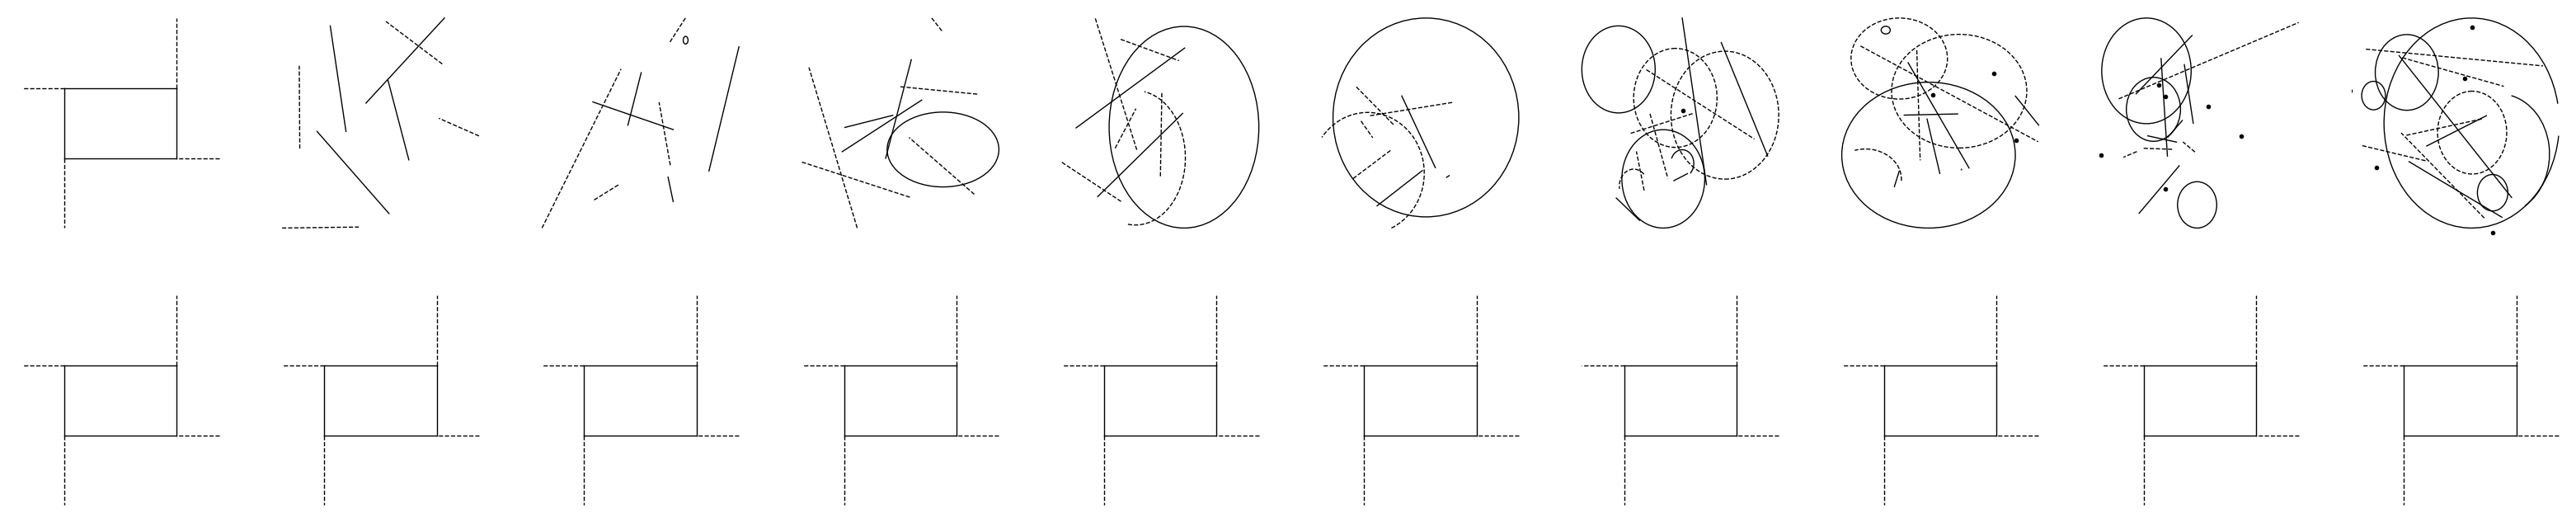

In [ ]:
model.eval()
fig, axes = plt.subplots(nrows = 2, ncols = 10, figsize=(40, 8))
node_seed, edge_seed = model.noise_scheduler.sample_latent(1)
sample = model.denoise(node_seed, edge_seed, axes, (nodes[None, 3].to(gpu_id), edges[None, 3].to(gpu_id)))
plt.show(fig)
plt.close(fig)

In [ ]:
model.eval()
scheduler = CosineNoiseScheduler(1000, gpu_id)
x = nodes[None,3].to(gpu_id)
t = 1
noisy, noise = scheduler(x, t)

SketchDataset.render_graph(x[...,1:].squeeze(0).cpu(), torch.zeros(size = (24, 24, 17)).cpu())
SketchDataset.render_graph(noisy[...,1:].squeeze(0).cpu(), torch.zeros(size = (24, 24, 17)).cpu())
timestep = torch.tensor([t], dtype = torch.int32, device = gpu_id)
pred_noise = model.forward(noisy, timestep)
pred = model.get_pred(pred_noise, noisy, t)
next = model.reverse(pred_noise, noisy, t)

SketchDataset.render_graph(pred[...,1:].squeeze(0).cpu(), torch.zeros(size = (24, 24, 17)).cpu())
SketchDataset.render_graph(next[...,1:].squeeze(0).cpu(), torch.zeros(size = (24, 24, 17)).cpu())
print("")

TypeError: CosineNoiseScheduler.forward() missing 1 required positional argument: 'timestep'

In [ ]:
# nodes = model.noise_scheduler.sample_latent(1)
# nodes = nodes.to(gpu_id)

# # SketchDataset.render_graph(nodes[0,...,1:].cpu(), torch.zeros(size = (24, 24, 17)).cpu())
# num_images = 10
# j = num_images - 1
# fig, axes = plt.subplots(nrows = 1, ncols = num_images, figsize=(40, 4))
# stepsize = int(model.max_timestep/num_images)
    
# for t in reversed(range(1, model.max_timestep)):
#     # model expects a timestep for each batch
#     batch_size = nodes.size(0)
#     time = torch.Tensor([t]).expand(1).int().to(gpu_id)
#     pred_noise = model.forward(nodes, time)
#     denoised_nodes = model.get_pred(pred_noise, nodes, t)
#     nodes = model.reverse(denoised_nodes, nodes, t)

#     if t % stepsize == 0:
#         SketchDataset.render_graph(nodes[0,...,1:].cpu(), torch.zeros(size = (24, 24, 17)).cpu(), axes[j])
#         # SketchDataset.render_graph(denoised_nodes[0,...,1:].cpu(), torch.zeros(size = (24, 24, 17)).cpu(), axes[1, j])
#         j = j - 1
    
# SketchDataset.render_graph(nodes[0,...,1:].cpu(), torch.zeros(size = (24, 24, 17)).cpu(), axes[0])
# # SketchDataset.render_graph(denoised_nodes[0,...,1:].cpu(), torch.zeros(size = (24, 24, 17)).cpu(), axes[1, 0])
# plt.show(fig)
# plt.close(fig)

In [ ]:
# model.eval()
# fig, axes = plt.subplots(nrows = 2, ncols = 10, figsize=(40, 8))
# seed = model.noise_scheduler.sample_latent(1)
# sample = model.denoise(seed, axes)
# plt.show(fig)
# plt.close(fig)

In [ ]:
# gpu_id = 0
# D = 9
# x0 = torch.eye(n = 1, m = D, device = gpu_id).unsqueeze(0)
# noise_scheduler = CosineNoiseScheduler(1000, device = gpu_id)
# t = torch.arange(0, 1, 1 / (1000 + 1), device = gpu_id)

# alpha = torch.zeros(1000, device = gpu_id)

# for i in range(1000):
#     x = x0.expand(10000, -1, -1)

#     latent, _ = noise_scheduler.apply_discrete_noise(x, i)

#     y = F.one_hot(torch.argmax(latent, dim = -1), D).float().mean(0).squeeze()

#     alpha[i] = y[0]

# plt.plot(t[1:].cpu(), alpha.cpu())
# plt.axhline(y=1/D, color='g', linestyle=':', label='1/D')
# plt.axhline(y=0, color='r', linestyle=':', label='0')
# plt.legend()